# Introduction to NER with Python
https://www.depends-on-the-definition.com/introduction-named-entity-recognition-python/

In [90]:
import pandas as pd
import numpy as np

data = pd.read_csv("../data/external/kaggle_ner_dataset/ner_dataset.csv", 
                   encoding = "latin1")
data = data.fillna(method="ffill")

In [91]:
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [92]:
words = list(set(data["Word"].values))
n_words = len(words); n_words

35178

### Sentence Getter

In [93]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                   s["POS"].values.tolist(),
                                                   s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try:
            s = self.data[self.data["Sentence #"] == "Sentence: "+str(self.n_sent)]
            self.n_sent += 1
            return s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist()
        except:
            self.empty = True
            return None, None, None

In [94]:
getter = SentenceGetter(data)
sent, pos, tag = getter.get_next()

In [95]:
print(sent)
print(pos)
print(tag)

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'IN', 'NNP', 'CC', 'VB', 'DT', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'DT', 'NN', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


### Memorization Classifier

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin

class MemoryTagger(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        voc = {}
        self.tags = []
        for x, t in zip(X,y):
            if t not in self.tags:
                self.tags.append(t)
            if x in voc:
                if t in voc[x]:
                    voc[x][t] +=1
                else:
                    voc[x][t] = 1
            else:
                voc[x] = {t: 1}
                
        self.memory = {}
        for k, d in voc.items():
            self.memory[k] = max(d, key=d.get)
            
    def predict(self, X, y=None):
        return [self.memory.get(x, "O") for x in X]
        

In [27]:
tagger = MemoryTagger()
tagger.fit(sent, tag)

In [29]:
tagger.predict(sent)
tagger.tags

['O', 'B-geo', 'B-gpe']

In [30]:
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import classification_report

words = data["Word"].values.tolist()
tags = data["Tag"].values.tolist()

D:\Programme\anaconda35\envs\mas\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
pred = cross_val_predict(estimator=MemoryTagger(), X=words, y=tags, cv=5)
report = classification_report(y_pred=pred, y_true=tags)
print(report)

             precision    recall  f1-score   support

      B-art       0.20      0.05      0.09       402
      B-eve       0.54      0.25      0.34       308
      B-geo       0.78      0.85      0.81     37644
      B-gpe       0.94      0.93      0.94     15870
      B-nat       0.42      0.28      0.33       201
      B-org       0.67      0.49      0.56     20143
      B-per       0.78      0.65      0.71     16990
      B-tim       0.87      0.77      0.82     20333
      I-art       0.04      0.01      0.01       297
      I-eve       0.39      0.12      0.18       253
      I-geo       0.73      0.58      0.65      7414
      I-gpe       0.62      0.45      0.52       198
      I-nat       0.00      0.00      0.00        51
      I-org       0.69      0.53      0.60     16784
      I-per       0.73      0.65      0.69     17251
      I-tim       0.58      0.13      0.21      6528
          O       0.97      0.99      0.98    887908

avg / total       0.94      0.95      0.94  

### Random Forest Approach

In [33]:
from sklearn.ensemble import RandomForestClassifier

def feature_map(word):
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                     word.isdigit(), word.isalpha()])

In [35]:
words = [feature_map(w) for w in data["Word"].values.tolist()]
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),
                        X=words, y=tags, cv=5)
report = classification_report(y_pred=pred, y_true=tags)
print(report)

             precision    recall  f1-score   support

      B-art       0.00      0.00      0.00       402
      B-eve       0.00      0.00      0.00       308
      B-geo       0.26      0.80      0.40     37644
      B-gpe       0.26      0.04      0.07     15870
      B-nat       0.00      0.00      0.00       201
      B-org       0.65      0.17      0.27     20143
      B-per       0.96      0.20      0.33     16990
      B-tim       0.29      0.32      0.30     20333
      I-art       0.00      0.00      0.00       297
      I-eve       0.00      0.00      0.00       253
      I-geo       0.00      0.00      0.00      7414
      I-gpe       0.00      0.00      0.00       198
      I-nat       0.00      0.00      0.00        51
      I-org       0.36      0.03      0.06     16784
      I-per       0.47      0.02      0.04     17251
      I-tim       0.50      0.06      0.11      6528
          O       0.97      0.98      0.97    887908

avg / total       0.88      0.87      0.86  

D:\Programme\anaconda35\envs\mas\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


enhance features with memory and context information

In [36]:
from sklearn.preprocessing import LabelEncoder

class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.memory_tagger = MemoryTagger()
        self.tag_encoder = LabelEncoder()
        self.pos_encoder = LabelEncoder()
        
    def fit(self, X, y):
        words = X["Word"].values.tolist()
        self.pos = X["POS"].values.tolist()
        tags = X["Tag"].values.tolist()
        self.memory_tagger.fit(words,tags)
        self.tag_encoder.fit(tags)
        self.pos_encoder.fit(self.pos)
        return(self)
    
    def transform(self, X, y=None):
        def pos_default(p):
            if p in self.pos:
                return self.pos_encoder.transform([p])[0]
            else:
                return -1
        
        pos = X["POS"].values.tolist()
        words = X["Word"].values.tolist()
        out = []
        for i in range(len(words)):
            w = words[i]
            p = pos[i]
            if i < len(words) - 1:
                wp = self.tag_encoder.transform(self.memory_tagger.predict([words[i+1]]))[0]
                posp = pos_default(pos[i+1])
            else:
                wp = self.tag_encoder.transform(['O'])[0]
                posp = pos_default(".")
            if i > 0:
                if words[i-1] != ".":
                    wm = self.tag_encoder.transform(self.memory_tagger.predict([words[i-1]]))[0]
                    posm = pos_default(pos[i-1])
                else:
                    wm = self.tag_encoder.transform(['O'])[0]
                    posm = pos_default(".")
            else:
                posm = pos_default(".")
                wm = self.tag_encoder.transform(['O'])[0]
            out.append(np.array([w.istitle(), w.islower(), w.isupper(), len(w), w.isdigit(), w.isalpha(),
                                 self.tag_encoder.transform(self.memory_tagger.predict([w]))[0],
                                 pos_default(p), wp, wm, posp, posm]))
        return out    
        
    

In [37]:
from sklearn.pipeline import Pipeline
pred = cross_val_predict(Pipeline([("feature_map", FeatureTransformer()), 
                                   ("clf", RandomForestClassifier(n_estimators=20, n_jobs=3))]),
                         X=data, y=tags, cv=5)
report = classification_report(y_pred=pred, y_true=tags)
print(report)

             precision    recall  f1-score   support

      B-art       0.17      0.08      0.11       402
      B-eve       0.37      0.25      0.30       308
      B-geo       0.83      0.86      0.84     37644
      B-gpe       0.98      0.93      0.95     15870
      B-nat       0.20      0.23      0.22       201
      B-org       0.73      0.64      0.68     20143
      B-per       0.82      0.75      0.79     16990
      B-tim       0.89      0.80      0.84     20333
      I-art       0.03      0.01      0.02       297
      I-eve       0.28      0.17      0.21       253
      I-geo       0.76      0.67      0.71      7414
      I-gpe       0.67      0.46      0.54       198
      I-nat       0.40      0.20      0.26        51
      I-org       0.73      0.68      0.70     16784
      I-per       0.85      0.75      0.80     17251
      I-tim       0.81      0.53      0.64      6528
          O       0.98      0.99      0.99    887908

avg / total       0.96      0.96      0.96  

### Neural Nets for Sequence Tagging

In [38]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words)
print(n_words)

tags = list(set(data["Tag"].values))
n_tags = len(tags)
print(n_tags)

getter = SentenceGetter(data)
sent=getter.get_next()
print(sent)

sentences = getter.sentences





35179
17
(['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.'], ['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'IN', 'NNP', 'CC', 'VB', 'DT', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'DT', 'NN', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O'])


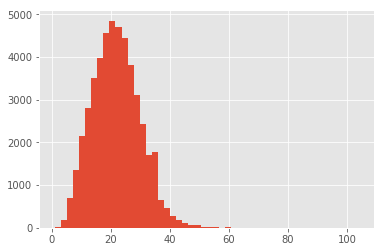

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [44]:
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [45]:
print(word2idx["Obama"])
print(tag2idx["B-geo"])

9376
0


In [46]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)
X[1]

array([12780, 27733, 32274,  7054,  8426,  2176, 30788, 10894,  2176,
        5049, 28130,  9496,  9387, 27838, 13190, 11325, 33889, 28706,
       18039, 16764, 30791, 32992, 23692,  4807, 15785, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178])

In [47]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y[1]

array([2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 8, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3])

In [48]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [49]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [50]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [51]:
model = Model(input, out)

In [52]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [53]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 90s 2ms/step - loss: 0.1405 - acc: 0.9643 - val_loss: 0.0604 - val_acc: 0.9826
Epoch 2/5
38846/38846 [==============================] - 95s 2ms/step - loss: 0.0550 - acc: 0.9841 - val_loss: 0.0494 - val_acc: 0.9851
Epoch 3/5
38846/38846 [==============================] - 96s 2ms/step - loss: 0.0458 - acc: 0.9867 - val_loss: 0.0459 - val_acc: 0.9862
Epoch 4/5
38846/38846 [==============================] - 97s 2ms/step - loss: 0.0414 - acc: 0.9879 - val_loss: 0.0445 - val_acc: 0.9864
Epoch 5/5
38846/38846 [==============================] - 97s 3ms/step - loss: 0.0383 - acc: 0.9888 - val_loss: 0.0435 - val_acc: 0.9869


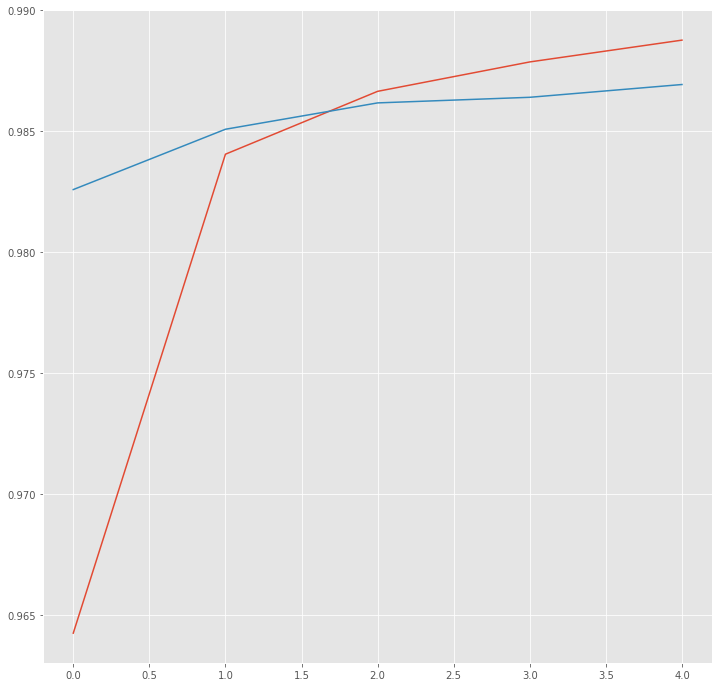

In [54]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [75]:
i = 1222
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w], tags[t], tags[pred]))

Word           ||True ||Pred
But            : O     O
citizens       : O     O
of             : O     O
communist      : O     O
Cuba           : B-geo B-geo
must           : O     O
get            : O     O
permission     : O     O
from           : O     O
the            : O     O
Havana         : B-geo B-geo
government     : O     O
to             : O     O
travel         : O     O
to             : O     O
Spain          : B-geo B-geo
if             : O     O
they           : O     O
are            : O     O
accepted       : O     O
for            : O     O
Spanish        : B-gpe B-gpe
citizenship    : O     O
.              : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPA

In [83]:


tmp = data[["Word", "Tag"]]
tmp.head()

,Word,Tag
0,Thousands,O
1,of,O
2,demonstrators,O
3,have,O
4,marched,O


In [87]:
tmp.to_csv("D:/Projects/python_learn/sequence_tagging/data/kaggle_ner_dataset.txt", sep=" ")